In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import os

# seaborn can be used to "prettify" default matplotlib plots by importing and setting as default
import seaborn as sns
sns.set() # Set searborn as default

## Load dataset

In [4]:
mat = scipy.io.loadmat('Silhouettes.mat')
Fem = mat['Fem'].ravel() - 1 # Get rid of outer dim, -1 due to stupid matlab indexing
Male = mat['Male'].ravel() - 1
num_female = Fem.size
num_male = Male.size
Xa = mat['Xa']
gamma = np.linspace(0.01, 0.99, 12) #  try in the range [0.01,0.99]

### 3 Implement and calculate a Regularized Discriminant Analysis (RDA) for the Silhouette data in Silhouettes.mat

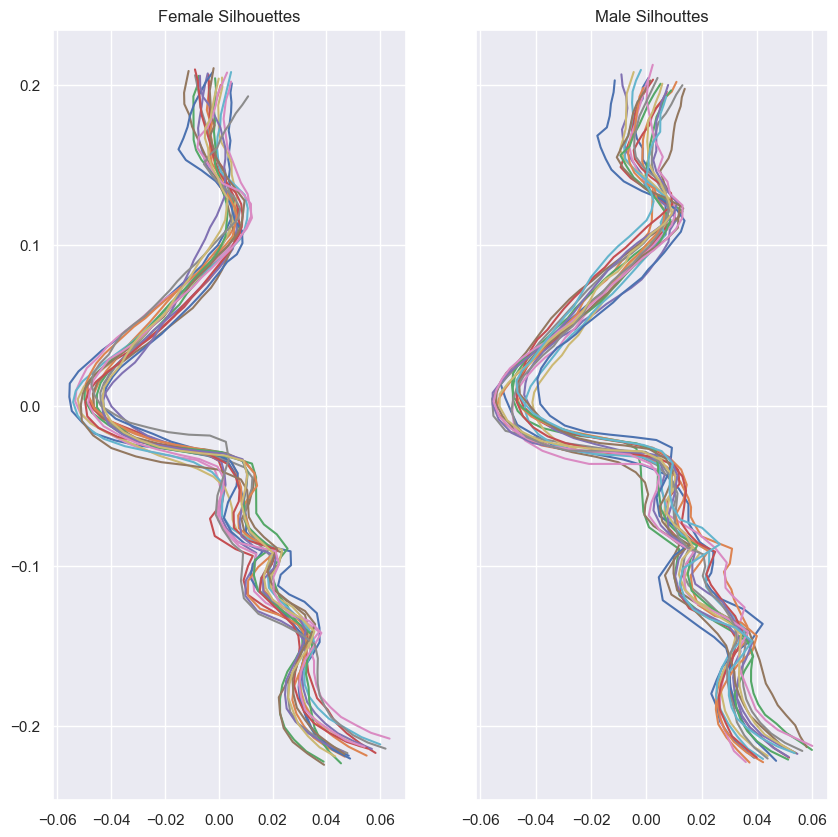

In [5]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10,10))
ax1.plot(Xa[Fem,:65].T, Xa[Fem, 65:].T)
ax1.set_title("Female Silhouettes")
ax2.plot(Xa[Male, :65].T, Xa[Male, 65:].T)
ax2.set_title("Male Silhouttes")
plt.show()

> (a) What happens when we vary $\gamma$ in RDA?

ValueError: shapes (17,17) and (2,) not aligned: 17 (dim 1) != 2 (dim 0)

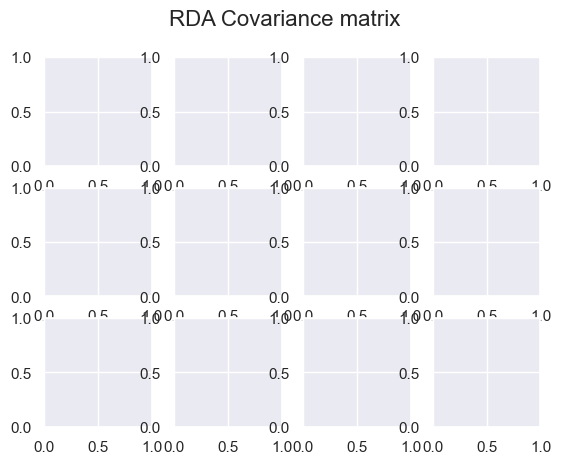

In [13]:
iterations = 100
gamma = np.linspace(0.01, 0.99, 12) #  try in the range [0.01,0.99]

cl_tr = np.zeros(iterations)
cl_tst = np.zeros(iterations)
train = np.zeros(len(gamma))
test = np.zeros(len(gamma))
s_test = np.zeros(len(gamma))

fig, axis = plt.subplots(3,4)

plt_col = 0
plt_row = -1
fig.suptitle('RDA Covariance matrix', fontsize=16)
for j in range(len(gamma)):
    for i in range(iterations):
        #Retrieve bootstrap sample. Hint: Use numpy's random.choice
        femP = np.random.choice(Fem,2)
        maleP = np.random.choice(Male,3)
        
        #Retrieve Out-of-Bootstrap samples. Hint. Use "List Comprehension". For x in Fem add to list if x not in femP ect.
        femOOB = [x for x in Fem if x not in femP]
        maleOOB = [x for x in Male if x not in maleP]
        
        #Concat gendered data sets
        train_sample = np.concatenate([femP, maleP]).tolist()
        test_sample = femOOB + maleOOB
        
        # get means of the two classes
        mean_fem = np.mean(femOOB)
        mean_male = np.mean(maleOOB)
        # Calculate the pooled within class covariance matrix
        cov_fem = np.cov(Xa[femOOB])
        cov_male = np.cov(Xa[maleOOB])
        sw = cov_fem * len(femOOB) / (len(femOOB) + len(maleOOB) - len(train_sample)) + cov_male * len(maleOOB) / (len(femOOB) + len(maleOOB) - len(train_sample))

        # Calculate the regularized discriminant analysis estimate of the covariance matrix
        
        srda = (1-gamma[j])*np.diag(sw) + gamma[j]*sw

        # predict train and test

        # Calculate the coefficients for the discriminant functions
        coef = np.dot(srda, [mean_fem,mean_male])

        # Calculate the constant terms for the discriminant functions
        prior_probabilities = np.array([len(femOOB), len(maleOOB)]) / (len(femOOB) + len(maleOOB))
        constants = -0.5 * np.sum([mean_fem,mean_male] * coef, axis=1) + np.log(prior_probabilities)

        # calculate the score
        score_fem = np.dot(femP, coef) + constants
        score_male = np.dot(maleP, coef) + constants

        #Compute classification accuracy
        class_true = np.ones((Xa.shape[0]))
        class_true[Male] = 2
        class_pred = (score_male>score_fem)+1

        cl_tr[i] = np.mean(class_true[train_sample]==class_pred[train_sample]) #classification rate/prediction accuracy train
        cl_tst[i] = np.mean(class_true[test_sample]==class_pred[test_sample]) #classification rate/prediction accuracy test

    train[j] = np.mean(cl_tr)
    test[j] = np.mean(cl_tst)
    s_test[j] = np.std(cl_tst)

    plt_col = j % 4
    if plt_col == 0:
        plt_row +=1
    axis[plt_row, plt_col].grid(None)
    axis[plt_row, plt_col].set_xticks([])
    axis[plt_row, plt_col].set_yticks([])
    axis[plt_row, plt_col].imshow(srda)
    plt.grid(None)
    
    
plt.show()   

plt.figure(4)
plt.plot(gamma,train,'r-')
plt.xlabel('gamma')
plt.ylabel('Classification rate')
plt.plot(gamma,test,'b-')
plt.plot(gamma,test-s_test,'b--')
plt.plot(gamma,test+s_test,'b--')
plt.legend(('train','test'))
plt.title('Prediciton accuracy', fontsize=16)
plt.show()